# Developing Trust in Predictions on Images with a Neural Network

I have created a model below that predicts whether an image is iconographic (1) or not (0)? We'll think together and do some coding that might help during EHL.

## Make the necessary imports

In [ ]:
from io import BytesIO
import zipfile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

from PIL import Image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Embedding, Flatten, LSTM, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import regularizers

## Download and resize the images

### We want all the images to be the same size without much distortion

In [ ]:
def resize(image, size=128):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    (h, w) = image.size[:2]

    # resize the image
    desired_size = size
    ratio = float(desired_size) / max(image.size[:2])
    new_size = tuple([int(x * ratio) for x in image.size[:2]])

    # new_size should be in (width, height) format
    image = cv2.resize(np.asarray(image), (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = np.random.randint(0, 256, (3,)).tolist()
    resized = cv2.copyMakeBorder(image, top, bottom, left, right,
                                 cv2.BORDER_CONSTANT, value=color)

    return resized

### We need to download the images and unzip their directories

In [ ]:
def download_normed_images(url, size=128):
    zipped_dataset_response = requests.get(url)
    zip_file = zipfile.ZipFile(BytesIO(zipped_dataset_response.content))
    filenames = zip_file.namelist()
    images = []
    for filename in filenames:
        with zip_file.open(filename) as f:
            try:
                image = Image.open(BytesIO(f.read()))
            except OSError:
                continue
        resized = resize(image, size=size)
        if resized.shape[-1] in (1, 3):
            images.append(resized)
    return images

### Now download the four different datasets

In [ ]:
painting_valid_url = 'https://www.dropbox.com/s/geu6zm8ik2joj0m/painting_valid.zip?dl=1'
painting_valid_images = download_normed_images(painting_valid_url, size=128)

painting_url = 'https://www.dropbox.com/s/2rcl4tg9s0ev1cx/painting.zip?dl=1'
painting_images = download_normed_images(painting_url, size=128)

iconography_valid_url = 'https://www.dropbox.com/s/2hlepqfwrpve4kp/iconography_valid.zip?dl=1'
iconography_valid_images = download_normed_images(iconography_valid_url, size=128)

iconography_url = 'https://www.dropbox.com/s/sctg7k8vklavzly/iconography.zip?dl=1'
iconography_images = download_normed_images(iconography_url, size=128)

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6029312 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1311848 bytes but only got 785. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 8. 
  warnings.warn(str(msg))


In [ ]:
Image.fromarray(iconography_images[4])

## Create X and y from the images and the `Tree` column

### Reduce the scale of X from (0, 255) to (0, 1) and change images to numpy arrays

In [ ]:
train_X = np.append(painting_images, iconography_images, axis=0) / 256
train_y = np.array([0 for im in painting_images] +
                   [1 for im in iconography_images]).reshape(-1, 1)
indices = np.arange(0, train_y.shape[0])
np.random.shuffle(indices)
train_X = np.array([train_X[i] for i in indices])
train_y = np.array([train_y[i] for i in indices])


valid_X = np.append(painting_valid_images, iconography_valid_images, axis=0) / 256
valid_y = np.array([0 for im in painting_valid_images] +
                   [1 for im in iconography_valid_images]).reshape(-1, 1)
indices = np.arange(0, valid_y.shape[0])
np.random.shuffle(indices)
valid_X = np.array([valid_X[i] for i in indices])
valid_y = np.array([valid_y[i] for i in indices])

In [ ]:
train_X.shape

(4114, 128, 128, 3)

## Create the convolutional model

In [ ]:
# This model is loosely modeled after AlexNet

model = Sequential()

# Conv Layer 1
model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), padding='valid', activation='relu',
                 input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Conv Layer 2
model.add(Conv2D(256, kernel_size=(5, 5), strides=1, padding='valid', activation='relu'))
model.add(BatchNormalization())

# Conv Layer 3
model.add(Conv2D(384, kernel_size=(3, 3), strides=1, padding='valid', activation='relu'))
model.add(BatchNormalization())

# Conv Layer 4
model.add(Conv2D(384, kernel_size=(3, 3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())

# Conv Layer 5
model.add(Conv2D(256, kernel_size=3, strides=(2, 2), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

# Dense layer 1
model.add(Dense(4096, activation='relu'))

# Dense layer 2
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.4))

# Output
model.add(Dense(1, activation='sigmoid'))

W0624 19:54:32.807276 139711375857536 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 384)         885120    
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 9, 384)         1

In [ ]:
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

W0624 19:54:33.314019 139711375857536 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Create several thousand image variations from our corpus
This `ImageDataGenerator` instance is a generator, which means the images are produced at runtime. This effectively makes our 4000+ images into several thousand images with a number of variations.

In [ ]:
datagen = ImageDataGenerator(
    shear_range=0.01,
    zoom_range=[0.9, 1.2],
    brightness_range=[0.9, 1.1],
    samplewise_center=True,
    samplewise_std_normalization=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rotation_range=10,
    fill_mode='constant')

datagen.fit(train_X)

## Fit the model on the data generator

In [ ]:
model.fit_generator(datagen.flow(train_X, train_y, batch_size=64), steps_per_epoch=train_X.shape[0] * 3 / 64,
                    epochs=12, validation_data=(valid_X, valid_y),
                    callbacks=[EarlyStopping('val_loss', patience=8, restore_best_weights=True,)])

Epoch 1/12
193/192 [==============================] - 48s 248ms/step - loss: 0.6253 - acc: 0.8284 - val_loss: 1.1831 - val_acc: 0.4684
Epoch 2/12
193/192 [==============================] - 44s 227ms/step - loss: 0.2652 - acc: 0.8931 - val_loss: 3.5930 - val_acc: 0.4967
Epoch 3/12
193/192 [==============================] - 44s 228ms/step - loss: 0.2338 - acc: 0.9081 - val_loss: 0.4564 - val_acc: 0.7930
Epoch 4/12
193/192 [==============================] - 44s 226ms/step - loss: 0.1821 - acc: 0.9297 - val_loss: 3.2601 - val_acc: 0.4967
Epoch 5/12
193/192 [==============================] - 44s 227ms/step - loss: 0.1697 - acc: 0.9355 - val_loss: 2.3063 - val_acc: 0.4989
Epoch 6/12
193/192 [==============================] - 44s 227ms/step - loss: 0.1463 - acc: 0.9431 - val_loss: 3.3136 - val_acc: 0.5142
Epoch 7/12
193/192 [==============================] - 44s 227ms/step - loss: 0.1303 - acc: 0.9514 - val_loss: 0.8939 - val_acc: 0.6623
Epoch 8/12
193/192 [==============================] - 4

## Evaluate the model on our "original" images (which are essentially unseen at this point)

In [ ]:
model.evaluate(x=valid_X, y=valid_y, batch_size=32)

459/459 [==============================] - 0s 821us/sample - loss: 0.4633 - acc: 0.7930


[0.46328471364019225, 0.7930283]

## Use the model to make a prediction

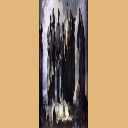

In [ ]:
Image.fromarray((train_X[28] * 256).astype(np.uint8))

In [ ]:
p = model.predict([[train_X[28]]])
a = train_y[28]
print('predicted:', p, '\nactual:', a)  # 1.0 == iconography; 0.0 == painting

predicted: [[0.8194155]] 
actual: [0]


## Explain the prediction

In [ ]:
!pip install lime

In [ ]:
from lime import lime_image

In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
explanation = explainer.explain_instance(train_X[27], model.predict, num_samples=50)

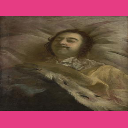

In [ ]:
Image.fromarray((train_X[27] * 256).astype(np.uint8))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
explanation.top_labels[0]

0

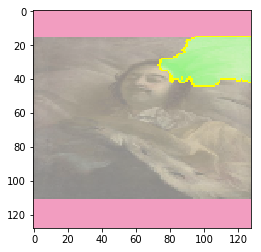

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
from lime import lime_text